In [43]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
# pip install ninja 2>> install.log
# git clone https://github.com/SIDN-IAP/global-model-repr.git tutorial_code 2>> install.log

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dissect.netdissect import nethook, tally
torch.cuda.set_device(0)

In [2]:
device = torch.device('cuda:0')

In [3]:
from parkinsonsNet import Network
model = torch.load("/home/anasa2/pre_trained/parkinsonsNet-rest_mpower-rest.pth")
print(model)

Network(
  (conv1): Sequential(
    (0): Conv1d(3, 8, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(32, 32, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

In [4]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import math
import json
import time
from matplotlib.pylab import plt
%matplotlib inline 
import itertools

class testMotionData(Dataset):

    def __init__(self, df, users, root_dir = '/home/jupyter/park/', transform=None):
      
        self.dataset = df
        self.root_dir = root_dir
        self.dataArray = []
        self.resultArray = []
        iterData = iter(self.dataset.iterrows())

        k = 0

        for j,z in zip(iterData,tqdm(range(int(len(self.dataset))))):
          j = j[1]
          healthcode = j[3]
        
          label = users.loc[healthcode][0]
          
          #print(j)
          for i in [8]:
            if(not math.isnan(j[i])):
                filedir = str(int(j[i]/10000))
                filename = str(j[i])
                length = len(filename)
                filename = filename[0:length-2]

                if(os.path.isfile(self.root_dir+filedir+"/"+filename+".json"))|(os.path.isfile(self.root_dir+"data"+"/"+filename+".json")):
                  if(os.path.isfile(self.root_dir+filedir+"/"+filename+".json")):
                    f = open(self.root_dir+filedir+"/"+filename+".json")
                  else:
                    f = open(self.root_dir+"data/"+filename+".json")
                try:
                    data = json.load(f)
                except:
                    continue
                self.dataArray.append([])
                self.dataArray[k].append([])
                self.dataArray[k].append([])
                self.dataArray[k].append([])
                for i in range(0,len(data),2):
                      x = data[i].get("rotationRate")
#                       print(i)
                      self.dataArray[k][0].append(x["x"])
                      self.dataArray[k][1].append(x["y"])
                      self.dataArray[k][2].append(x["z"])
            
                stdev = np.std(np.asarray(self.dataArray[k]))
                mean = np.mean(np.asarray(self.dataArray[k]))
                self.dataArray[k] = ((np.asarray(self.dataArray[k])-mean)/stdev).tolist()
                        
                self.dataArray[k][0] = correct_batch(self.dataArray[k][0])
                self.dataArray[k][1] = correct_batch(self.dataArray[k][1])
                self.dataArray[k][2] = correct_batch(self.dataArray[k][2])
                
                
                

                if(label):
                  self.resultArray.append(1)
                else:
                  self.resultArray.append(0)
                

                k = k + 1



        self.dataArray = np.asarray(self.dataArray)
        unique, counts = np.unique(np.array(self.resultArray), return_counts=True)
        print(dict(zip(unique, counts)))



    def __len__(self):
        return len(self.resultArray)

    def __getitem__(self, idx):
        sample = {'data': self.dataArray[idx], 'result': self.resultArray[idx]}

        return sample

In [5]:
# import numpy as np
# def pad_zero(arr,length):
#     while(len(arr)<length):
#         arr = np.append(arr,0)
#     return arr[:length]

In [6]:
# def trans_equal(ten,length=1000):
#     return torch.tensor([pad_zero(ten[0][0].cpu().numpy(),length),pad_zero(ten[0][1].cpu().numpy(),length),pad_zero(ten[0][2].cpu().numpy(),length)])

## Find Masks

In [7]:
from torchvision.utils import save_image
import os
import pandas as pd
from signal_purtubation import extremal_perturbation
import signal_purtubation


masked = []
model.to(device).eval()
model = model.float()

dataloader = torch.load("/home/anasa2/originalParkinsonsDataloaders/val_loader.pth")

      

In [8]:
# counter to keep count of the conv layers
counter = 0 
modules = {}
conv_layers = []
for top,module in model.named_children():
    for block,m1 in module.named_children():
        if type(m1) == nn.Conv1d:
            counter += 1
            conv_layers.append(m1)
            modules.update({""+top:m1})
          
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 8


In [9]:
itr = iter(dataloader)

In [10]:
batch = itr.next()
sample = batch["data"]
sample_label = batch["result"]

In [11]:
while(True):
    try: 
        batch = next(itr) 
    except:
        break 

    sample  = torch.cat((sample, batch["data"]), dim=0)
    sample_label  = torch.cat((sample_label, batch["result"]), dim=0)
    
data = torch.FloatTensor(sample.cpu().float()).to(device)

In [12]:
datapoint = torch.FloatTensor(np.random.rand(3,4000)).to(device)
datapoint_label = torch.tensor(0)

In [13]:
# Sample output
prediction = torch.sigmoid(model(datapoint.unsqueeze(0)))
prediction

tensor([[0.2018]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [14]:
from operator import itemgetter
from captum.attr import LayerActivation,LayerConductance, LayerGradientXActivation, NeuronConductance
from tqdm.notebook import tqdm

def get_topk_units(model, inputs, labels, target, sample_size=100):
  activations = {}
  count = 0
  for idx in tqdm(range(len(inputs))):
    if(count > sample_size):
      break
    if(labels[idx].item()==target):
      count+=1
      input = inputs[idx]
      for layer in modules:
        attr_algo = LayerConductance(model, modules[layer])
        attributions = attr_algo.attribute(input.unsqueeze(0)).squeeze()
        for i, unit in enumerate(attributions.squeeze()):
          if((layer,i) not in activations):
            activations.update({(layer,i):sum(unit).item()})
          else:
            activations[(layer,i)] += sum(unit).item()


  results = []
  for (key, value), top in zip(sorted(activations.items(), key = itemgetter(1), reverse = True),range(10)):
        results.append((key, value))
        

  return results



In [15]:
get_topk_units(model, [datapoint], [datapoint_label],1)

[]

In [16]:
unit = 56
layer = 5

In [17]:
import torch.nn.functional as F
model.cuda()
model.eval()

filters = []
##################################################### OOD Signal #####################################################

results = [conv_layers[0](datapoint.unsqueeze(0).cuda())]
for i in range(1, layer):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))     


layer_viz = results[-1][0,unit,:]

test_features= layer_viz.cpu().detach().numpy()
search_query = np.asarray([test_features])

true_target = torch.argmax(datapoint_label).item()

In [18]:
import torch.nn.functional as F
from torch.autograd import Variable

overall_layer = float("-inf")
model.cuda()
model.eval()
num_correct = 0
training_data = []



for (tensor, y) in tqdm(zip(data,sample_label)):

        results = [conv_layers[0](tensor.unsqueeze(0))]
        for i in range(1, layer):
        # pass the result from the last layer to the next layer
            results.append(conv_layers[i](results[-1])) 

        filters=[]

        layer_viz = results[-1][0,unit,:]


        training_data.append(layer_viz.cpu().detach().numpy())



In [19]:
  ##################################################### Create Index #####################################################

import faiss
import numpy as np
import math

D = len(search_query[0])
N = 100
# Xt = np.random.random((1000, D)).astype(np.float32)  # 10000 vectors for training
# X = np.random.random((N, D)).astype(np.float32)

# Param of PQ
M = 1  # The number of sub-vector. Typically this is 8, 16, 32, etc.
nbits = 8 # bits per sub-vector. This is typically 8, so that each sub-vec is encoded by 1 byte

# Param of IVF
nlist = int(math.sqrt(N))  # The number of cells (space partition). 

# Param of HNSW
hnsw_m = 32  # The number of neighbors for HNSW. This is typically 32

# Setup
quantizer = faiss.IndexHNSWFlat(D, hnsw_m)
index = faiss.IndexIVFPQ(quantizer, D, nlist, M, nbits)


In [20]:
print("Training...")
index.train(np.asarray(training_data))
print("Adding Dense Vectors...")
index.add(np.asarray(training_data))

Training...
Adding Dense Vectors...


In [21]:
faiss.write_index(index,"test_index.index")

In [22]:
import faiss

index = faiss.read_index("test_index.index")

In [23]:
# Search
index.nprobe = 8  # Runtime param. The number of cells that are visited for search.
topk = 4000
dists, ids = index.search(search_query, k=topk)

print(ids)
print(dists)


[[ 213 1003 3455 ... 2762 2392 1045]]
[[ 887.6038  887.6038  887.6038 ... 4085.9868 4085.9868 4085.9868]]


In [24]:
# from signal_purtubation import extremal_perturbation
# def get_purturbation(x, y, area):
#     x = x.unsqueeze(0).unsqueeze(3)
#     x = torch.FloatTensor(x.cpu()).cuda()
#     mask,_ = extremal_perturbation(
#             model, x, y.item(),
#             reward_func=signal_purtubation.simple_reward,
#             perturbation="blur",
#             debug=True,
#             areas=[area],
#             smooth=0.01,
#             max_iter=100
#         )

#     ## Crop Important Area
#     dat=torch.round(mask)[0].cpu().detach().numpy() # 'sharpen' mask

#     true_points = np.argwhere(dat)

#     print(true_points)
#     if len(true_points) != 0:
#         top_left = true_points.min(axis=0)
#         # take the largest points and use them as the bottom right of your crop
#         bottom_right = true_points.max(axis=0)
#         return top_left,bottom_right

#     return -1,-1
    

In [25]:
# num = 0
# for i,d in zip(ids[0][8:],dists[0][8:]): 
#   box = get_purturbation(data[i],sample_label[i],0.1)
#   print(box)
#   num+=1

In [26]:
def get_window(a, thresh, window_size=20):
    m = a>thresh
    best_x = 0
    best_y = 0
    max_d = 0
    x = 0
    y = 0
    for i in range(len(m)):
        if(m[i]):
            y+=1
        else:
            if(y-x > max_d):
                best_x = x
                best_y = y
                max_d = y-x

            x=y
    if(y-x > max_d):
                best_x = x
                best_y = y
                max_d = y-x
    # print(m)

    return [best_x,best_y]

In [27]:
from matplotlib import patches
def plot_signal(signals, boundaries, label):
    i = 0
    fig = plt.figure(figsize=(40,40))    
    ax = fig.add_subplot(4, 4, i + 1)
    i += 1
    for s,b in zip(signals,boundaries):
        rect = patches.Rectangle((b[0],-25),b[1],40,linewidth=1,edgecolor='black' ,facecolor='none')
        ax.add_patch(rect)
        ax.set_title("Entire Signal")

        ax.plot(s[0],color='blue',label='x')
        ax.plot(s[1],color='green',label='y')
        ax.plot(s[2],color='red',label='z')
        ax.set_xlim(0,2000)
        ax.set_ylim(-15,15)
     
        ax = fig.add_subplot(4, 4, i + 1)
        i += 1
        
        ax.set_title("Target Region From "+str(b[0])+" to "+str(b[1])+" For Label: "+str(label))


        zeros = [0]*b[0]

        x = np.concatenate((zeros,s[0][b[0]:b[1]]),axis=0)
        y = np.concatenate((zeros,s[1][b[0]:b[1]]),axis=0)
        z = np.concatenate((zeros,s[2][b[0]:b[1]]),axis=0)

        ax.plot(x,color='blue',label='x')
        ax.plot(y,color='green',label='y')
        ax.plot(z,color='red',label='z')

        ax.set_xlim(0,2000)
        ax.set_ylim(-15,15)

    plt.legend()
    plt.show()

In [32]:
def viz_signal(signals, signal_labels, activation, threshold=0.8, window_size=20):
    a = activation
    x,y = get_window(a,threshold,window_size=window_size)
    plot_signal([signals],[[x-5,y+5]] if x >5 else [[x,y+5]],[signal_labels])
    
    return x,y


OOD Signal


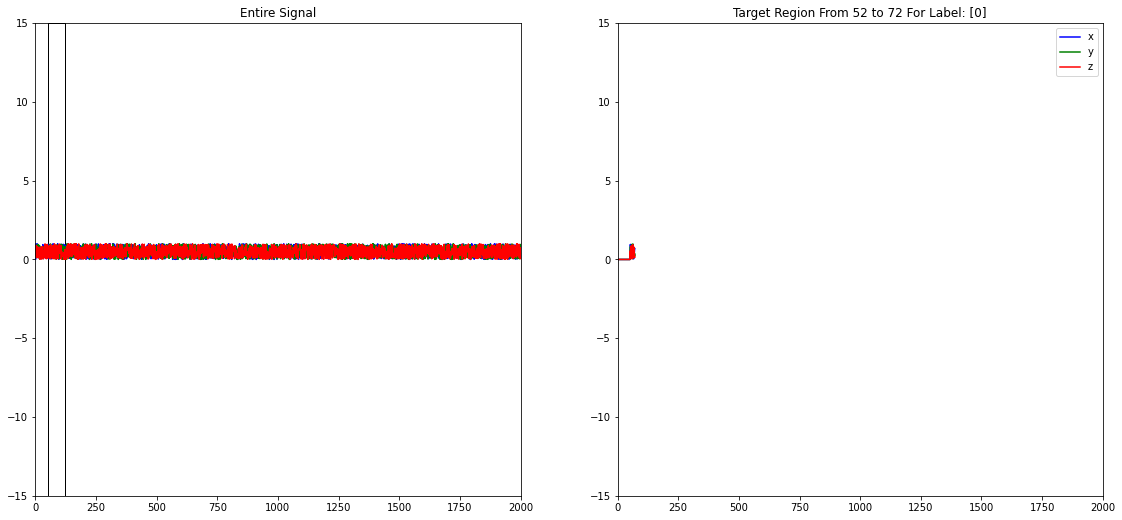

Mean X Value: 

0.5007771


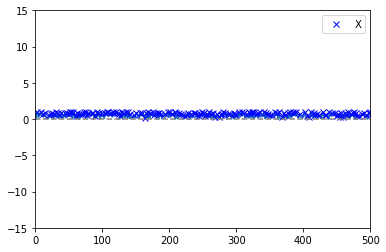

Mean Y Value: 

0.50161594


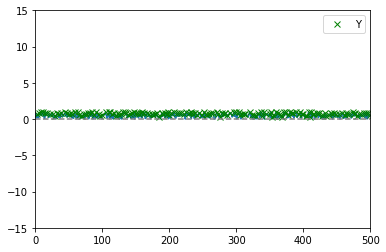

Mean Z Value: 

0.48451263


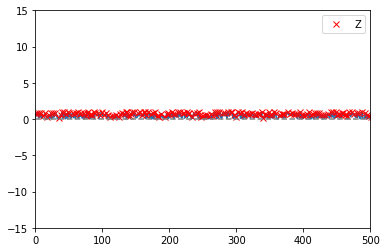

In [53]:
    print("OOD Signal")
    
    d = datapoint.cpu().numpy()
    left,right = [0,2000] 
    viz_signal(d,datapoint_label.item(),training_data[10])

    x = d[0][left:right]
    y = d[1][left:right]
    z = d[2][left:right]

    print("Mean X Value: \n")
    print(np.mean(x))

    peaks, _ = find_peaks(x, height=0)
    plt.plot(x)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, x[peaks], "x", label="X",color="blue")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.legend()
    plt.show()

    print("Mean Y Value: \n")
    print(np.mean(y))

    peaks, _ = find_peaks(y, height=0)
    plt.plot(y)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, y[peaks], "x",label="Y",color="green")
    plt.plot(np.zeros_like(y), "--", color="gray")
    plt.legend()
    plt.show()

    print("Mean Z Value: \n")
    print(np.mean(z))

    peaks, _ = find_peaks(z, height=0)
    plt.plot(z)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, z[peaks], "x",label="Z",color="red")
    plt.plot(np.zeros_like(z), "--", color="gray")
    plt.legend()
    plt.show()

Similar Signals


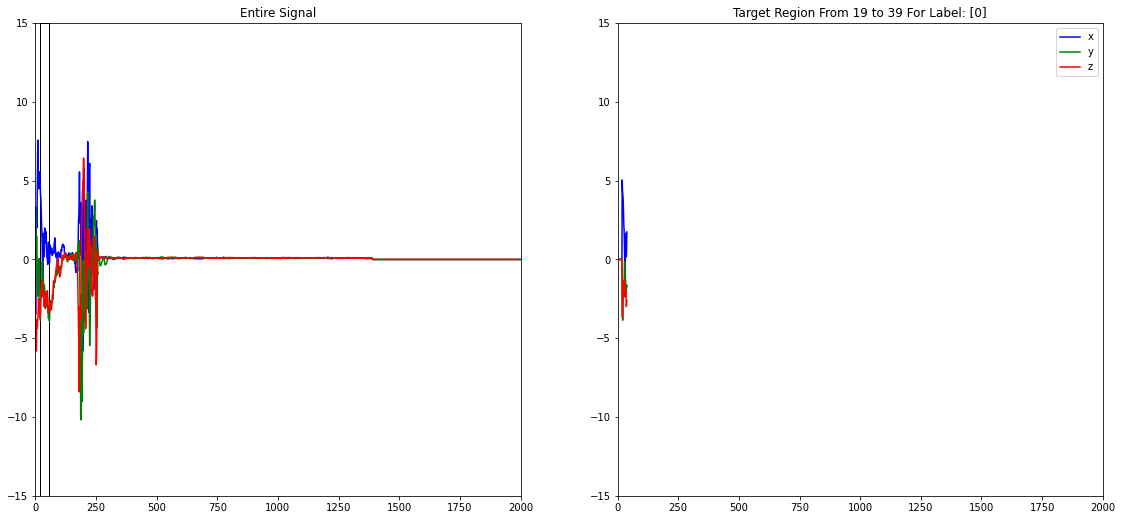

Mean X Value: 

0.56082755


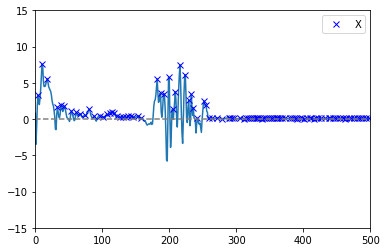

Mean Y Value: 

-0.52678263


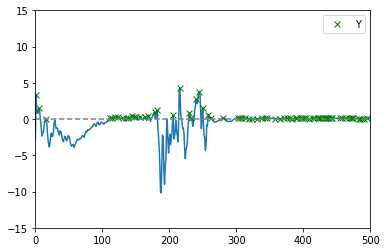

Mean Z Value: 

-0.52146405


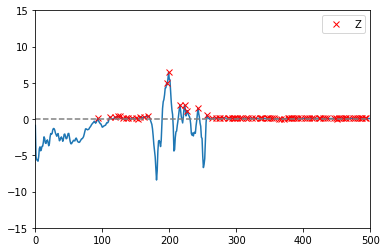

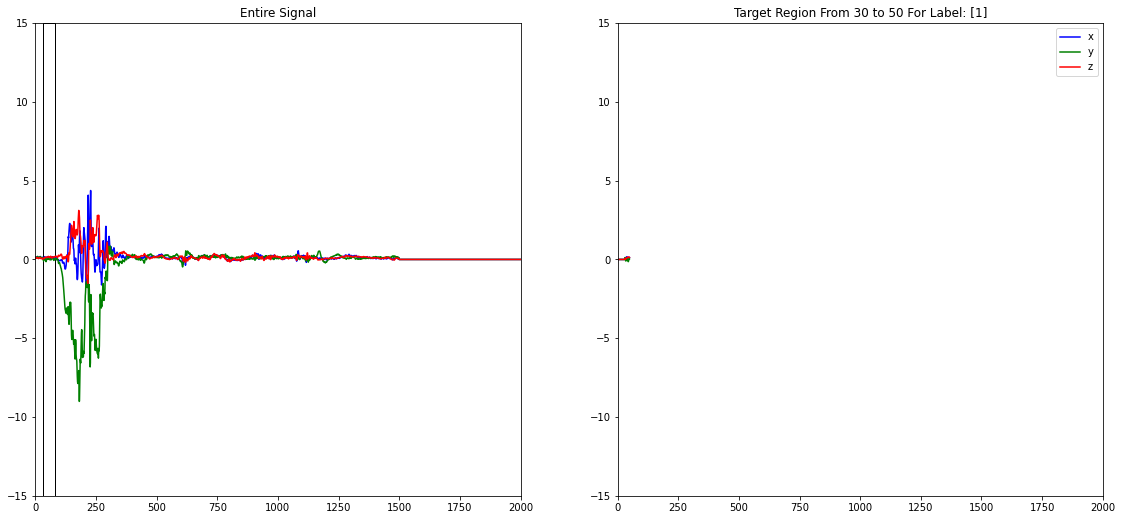

Mean X Value: 

0.28143665


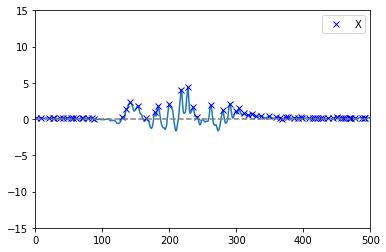

Mean Y Value: 

-1.4727966


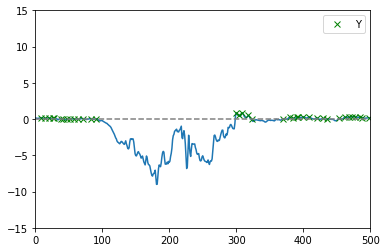

Mean Z Value: 

0.4751886


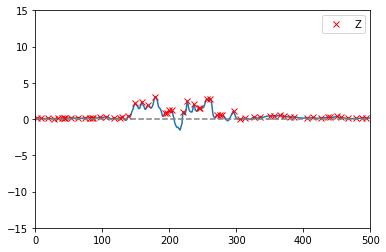

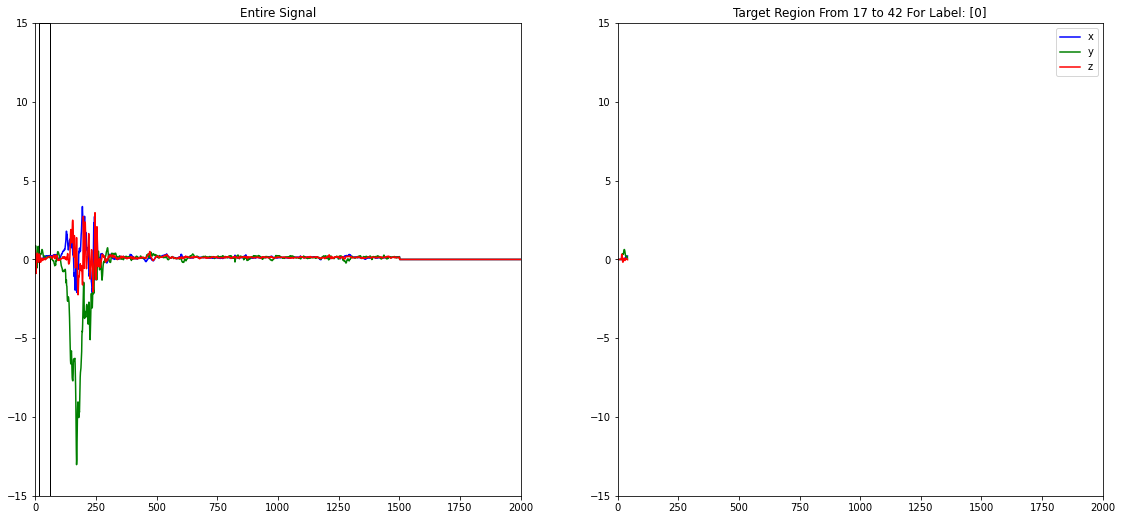

Mean X Value: 

0.22469877


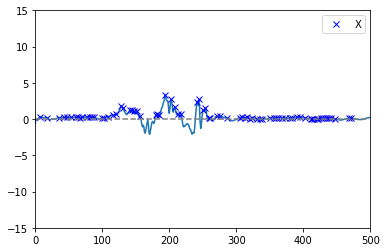

Mean Y Value: 

-1.1303229


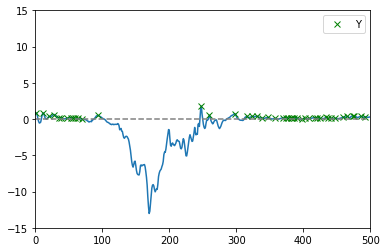

Mean Z Value: 

0.12517372


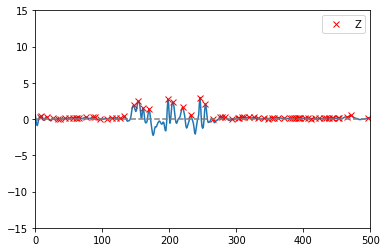

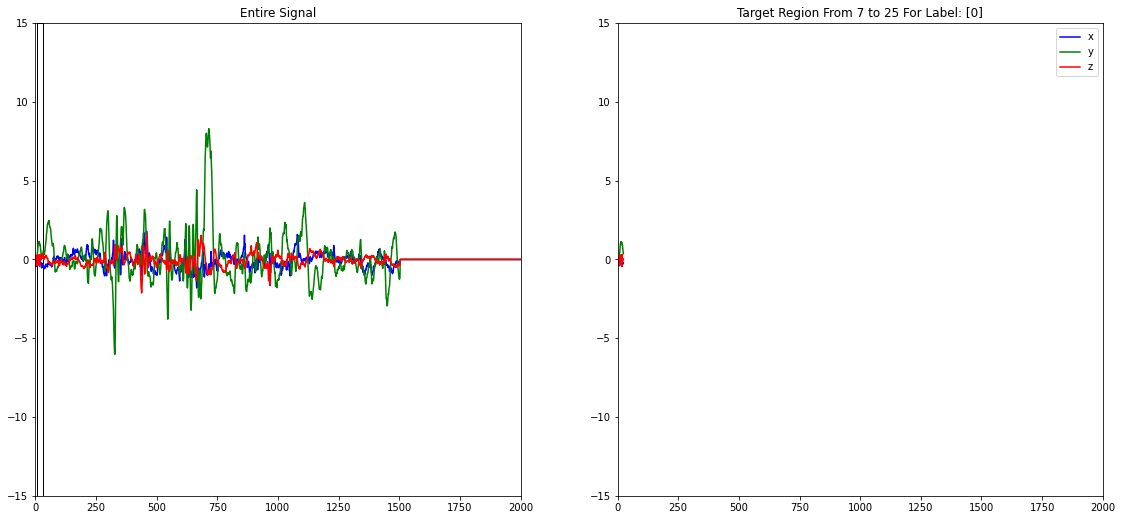

Mean X Value: 

0.025782788


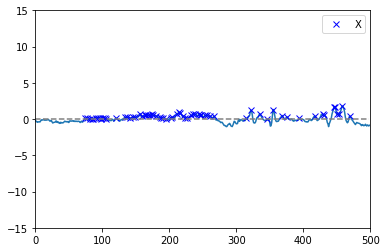

Mean Y Value: 

0.21694332


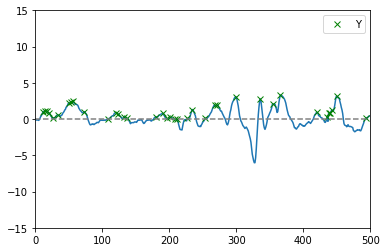

Mean Z Value: 

-0.07549686


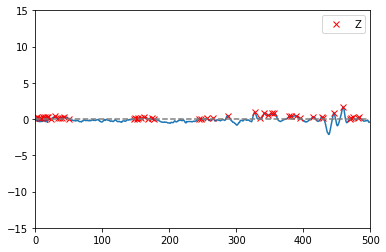

In [54]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

print("Similar Signals")

for i in ids[0][:topk]:
    d = data[i].cpu().numpy()
    left,right = [0,500] 
    viz_signal(d,sample_label[i].item(), training_data[i])

    x = d[0][left:right]
    y = d[1][left:right]
    z = d[2][left:right]


    print("Mean X Value: \n")
    print(np.mean(x))
    peaks, _ = find_peaks(x, height=0)
    plt.plot(x)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, x[peaks], "x", label="X",color="blue")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.legend()
    plt.show()

    print("Mean Y Value: \n")
    print(np.mean(y))
    peaks, _ = find_peaks(y, height=0)
    plt.plot(y)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, y[peaks], "x",label="Y",color="green")
    plt.plot(np.zeros_like(y), "--", color="gray")
    plt.legend()
    plt.show()


    print("Mean Z Value: \n")
    print(np.mean(z))
    peaks, _ = find_peaks(z, height=0)
    plt.plot(z)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, z[peaks], "x",label="Z",color="red")
    plt.plot(np.zeros_like(z), "--", color="gray")
    plt.legend()
    plt.show()

Not Similar


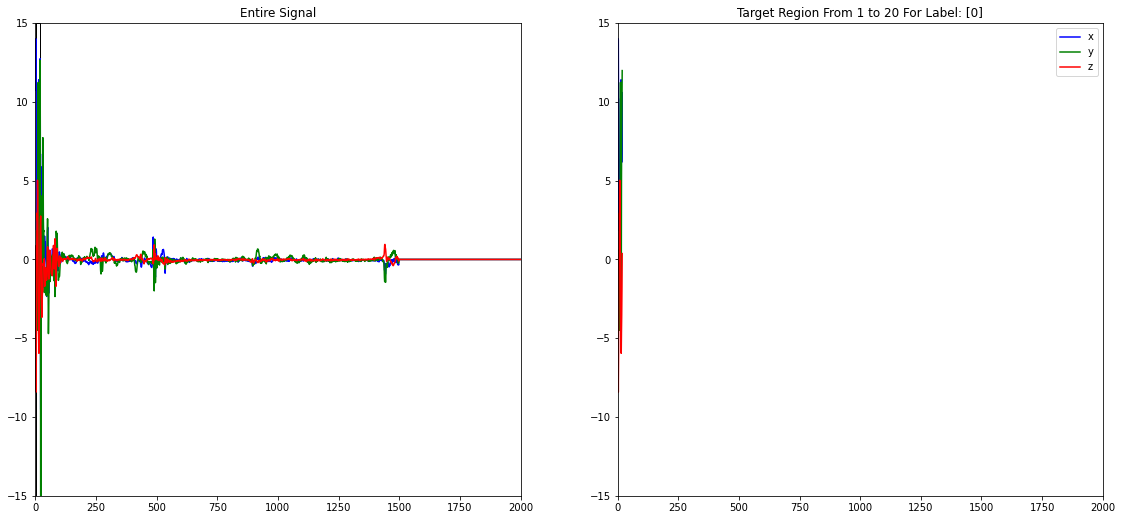

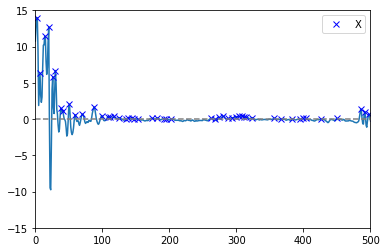

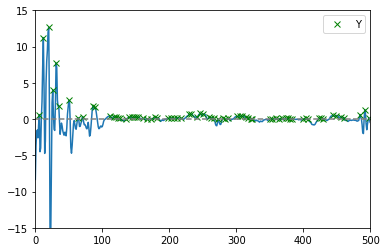

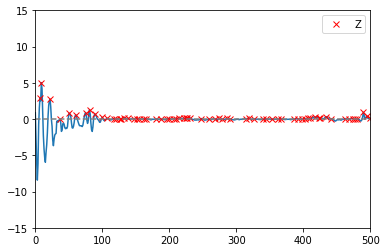

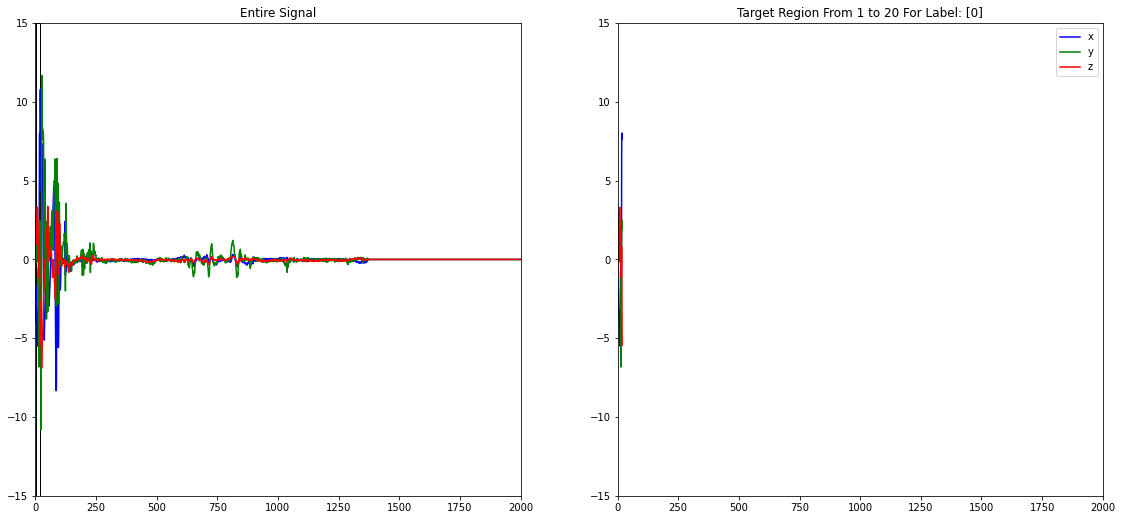

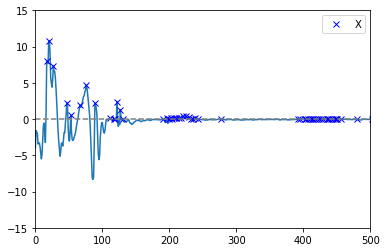

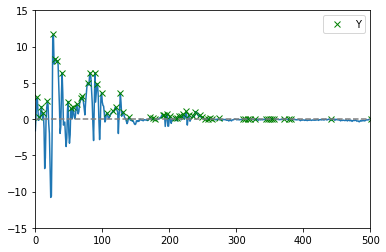

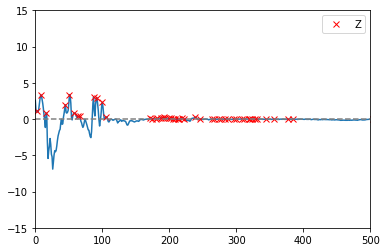

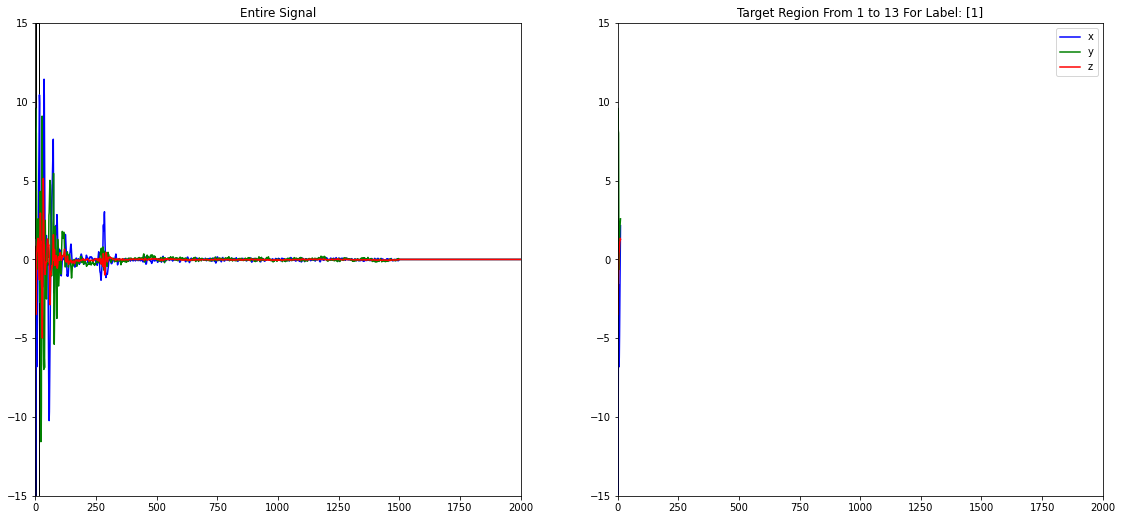

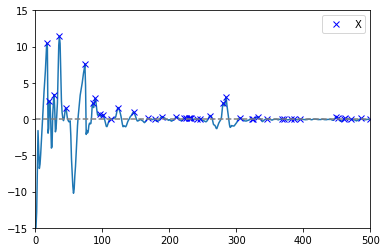

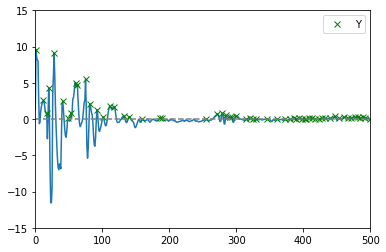

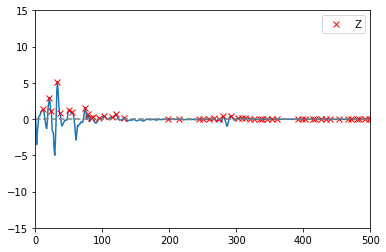

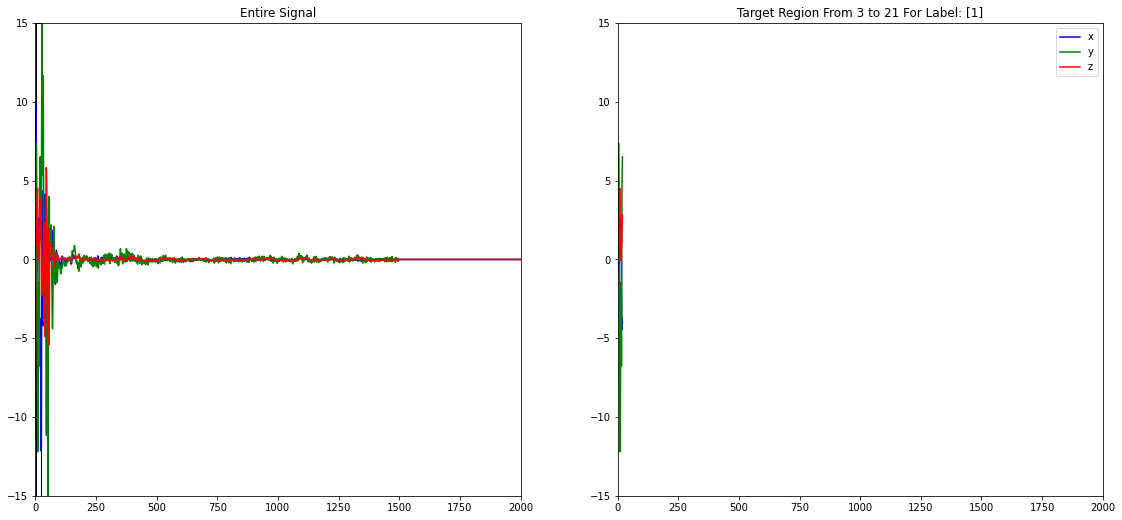

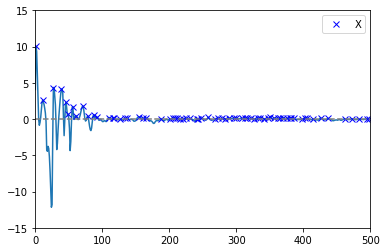

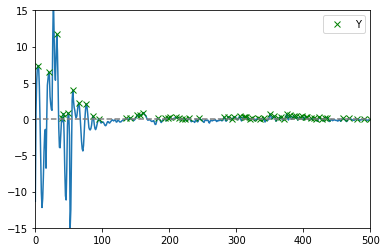

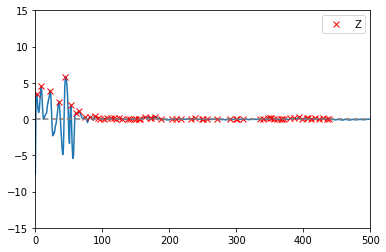

In [55]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

print("Not Similar")

for i in ids[0][-bottomk:]:
    d = data[i].cpu().numpy()
    left,right = [0,2000] 
    viz_signal(d,sample_label[i].item(), training_data[i])

    x = d[0][left:right]
    y = d[1][left:right]
    z = d[2][left:right]

    peaks, _ = find_peaks(x, height=0)
    plt.plot(x)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, x[peaks], "x", label="X",color="blue")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.legend()
    plt.show()


    peaks, _ = find_peaks(y, height=0)
    plt.plot(y)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, y[peaks], "x",label="Y",color="green")
    plt.plot(np.zeros_like(y), "--", color="gray")
    plt.legend()
    plt.show()


    peaks, _ = find_peaks(z, height=0)
    plt.plot(z)
    plt.axis([0, 500, -15, 15])
    plt.plot(peaks, z[peaks], "x",label="Z",color="red")
    plt.plot(np.zeros_like(z), "--", color="gray")
    plt.legend()
    plt.show()

In [65]:
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from torchray.benchmark import get_example_data, plot_example

model.cpu();

# Grad-CAM backprop.
saliency_layer = get_module(model, 'conv1')
probe = Probe(saliency_layer, target='output')

y = model(datapoint.unsqueeze(0).cpu())
z = y[0, 1]
z.backward()

saliency = gradient_to_grad_cam_saliency(probe.data[0])


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
# Plots.
plot_example(datapoint, saliency, 'grad-cam backprop', 1)